# Model Training

In [43]:
# Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

In [44]:
# Hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

classes = ['Apple', 'Banana', 'Orange']

# Custom transform to resize and keep the aspect ratio
class ResizeWithAspectRatio:
    def __init__(self, size):
        self.size = size  # The target size (width, height)
    
    def __call__(self, img):
        # Get the original width and height
        w, h = img.size
        target_w, target_h = self.size
        
        # Compute the scaling factor to keep the aspect ratio
        ratio_w = target_w / w
        ratio_h = target_h / h
        ratio = min(ratio_w, ratio_h)  # Use the smaller ratio to fit the image

        # Resize the image while preserving aspect ratio
        new_w = int(w * ratio)
        new_h = int(h * ratio)
        img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

        # Create a new image with the target size and paste the resized image
        new_img = Image.new("RGB", self.size, (255, 255, 255))  # White padding
        new_img.paste(img, ((target_w - new_w) // 2, (target_h - new_h) // 2))

        return new_img

transform = transforms.Compose([
    ResizeWithAspectRatio((64, 64)), 
    transforms.ToTensor(),      
    transforms.Normalize((0.5,), (0.5,))
])


In [45]:
class CNN(nn.Module):
    def __init__(self, classes, num_epochs=num_epochs):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # image size
        self.fc2 = nn.Linear(128, len(classes))  # n output classes 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.num_epochs = num_epochs    

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 16 * 16) 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

        

def train_model(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(model.num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to('cpu'), labels.to('cpu')

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{model.num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")


def visualize_predictions(model, test_loader):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to('cpu'), labels.to('cpu')
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) 
        plt.title(f"True: {labels[i].item()}, Pred: {predicted[i].item()}")
        plt.axis('off')
    plt.show()

def visualize_incorrect(model, test_dataset):
    model.eval()
    loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    images, labels = next(iter(loader))
    images, labels = images.to('cpu'), labels.to('cpu')
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    incorrect = 0
    classes = test_dataset.classes
    for i in range(len(test_dataset)):
        if labels[i].item() == predicted[i].item():
            continue
        plt.subplot(2, 3, incorrect + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) 
        plt.title(f"True: {classes[labels[i].item()]}, Pred: {classes[predicted[i].item()]}")
        plt.axis('off')
        incorrect += 1
        if incorrect == 6:
            break
    plt.show()

    
    


In [46]:
# Datasets: All Original Images

train_dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\train', transform=transform)  
test_dataset = datasets.ImageFolder(root='Datasets\\mbkinaci\\fruit-images-for-object-detection\\test', transform=transform)   

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [47]:
# Model for All Original Images

model = CNN(classes)     
model.apply(init_weights)
    
train_model(model, train_loader)
evaluate_model(model, test_loader)
#visualize_predictions(model, test_loader)

Epoch [1/10], Loss: 1.1253
Epoch [2/10], Loss: 0.5452
Epoch [3/10], Loss: 0.3494
Epoch [4/10], Loss: 0.3060
Epoch [5/10], Loss: 0.2753
Epoch [6/10], Loss: 0.1578
Epoch [7/10], Loss: 0.1113
Epoch [8/10], Loss: 0.1049
Epoch [9/10], Loss: 0.0440
Epoch [10/10], Loss: 0.0552
Accuracy: 96.36%


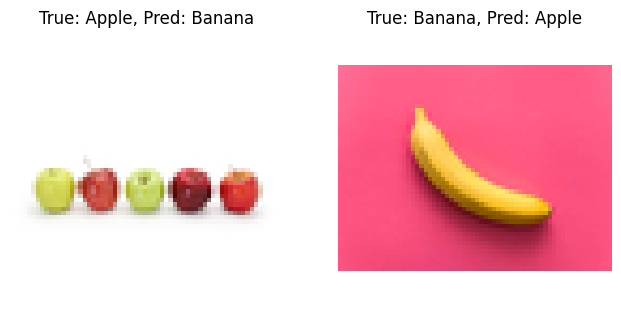

In [48]:
visualize_incorrect(model, test_dataset)

In [49]:
from typing import Dict, List, Tuple, Union
from pathlib import Path

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, allowed_classes, transform=None):
        self.allowed_classes = allowed_classes
        super().__init__(root=root, transform=transform)

    def find_classes(self, directory: Union[str, Path]) -> Tuple[List[str], Dict[str, int]]:
        classes, class_to_idx = super().find_classes(directory)
        classes = [class_name for class_name in classes if class_name in self.allowed_classes]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

In [50]:
# Datasets: All Synthetic Images

root_dir = 'Datasets\\DiegoP-S\\DatasetSynthesis'
allowed_folders = classes
train_dataset2 = CustomImageFolder(root=root_dir, allowed_classes=allowed_folders, transform=transform)
train_loader2 = DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True)

print(train_dataset2.classes)


['Apple', 'Banana', 'Orange']


In [51]:
# Model for All Synthetic Images

model2 = CNN(classes)     
model2.apply(init_weights)
    
train_model(model2, train_loader2)
evaluate_model(model2, test_loader)

Epoch [1/10], Loss: 1.4107
Epoch [2/10], Loss: 0.9705
Epoch [3/10], Loss: 0.5470
Epoch [4/10], Loss: 0.3589
Epoch [5/10], Loss: 0.2080
Epoch [6/10], Loss: 0.1162
Epoch [7/10], Loss: 0.0694
Epoch [8/10], Loss: 0.0603
Epoch [9/10], Loss: 0.0910
Epoch [10/10], Loss: 0.0415
Accuracy: 63.64%


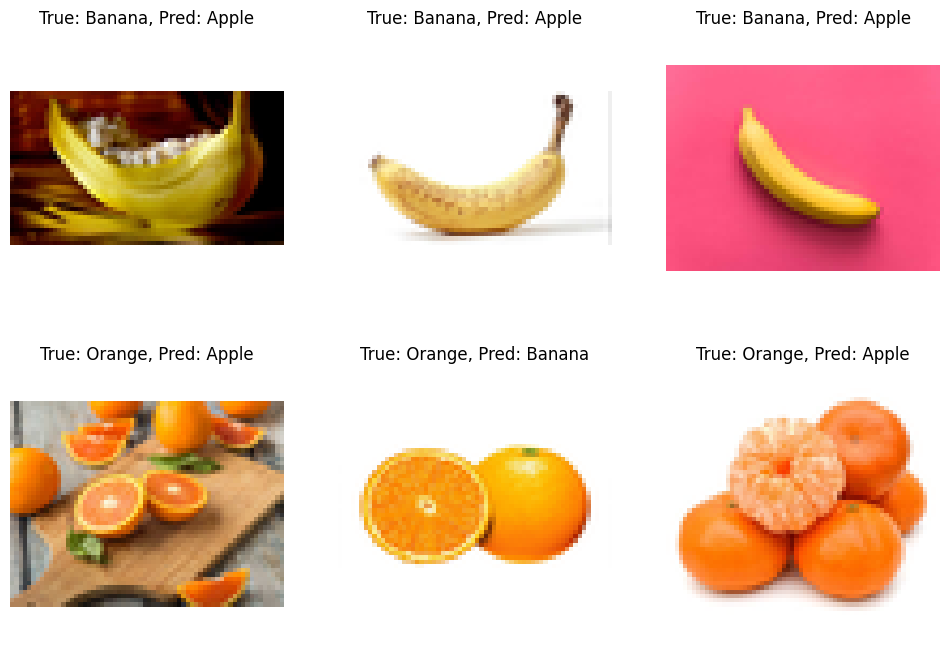

In [52]:
visualize_incorrect(model2, test_dataset)


In [53]:
# Datasets: Synthetic Images 50% Original 50%

synthetic_dataset = train_dataset2
original_dataset = train_dataset

def get_class_indices(dataset):
    """Return a dictionary with class indices grouped by category."""
    class_indices = {class_name: [] for class_name in dataset.classes}
    for idx, (_, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        class_indices[class_name].append(idx)
    return class_indices

synthetic_indices = get_class_indices(synthetic_dataset)
original_indices = get_class_indices(original_dataset)

print(synthetic_indices)
print(original_indices)

def sample_indices(synthetic_indices, original_indices, syn_ratio=0.5, orig_ratio=0.5):
    combined_indices = []
    for category in synthetic_indices.keys():
        syn_count = int(len(synthetic_indices[category]) * syn_ratio)
        orig_count = int(len(original_indices[category]) * orig_ratio)

        syn_sample = random.sample(synthetic_indices[category], min(syn_count, len(synthetic_indices[category])))
        orig_sample = random.sample(original_indices[category], min(orig_count, len(original_indices[category])))

        combined_indices.extend(syn_sample + orig_sample)

    return combined_indices

combined_indices = sample_indices(synthetic_indices, original_indices)


combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader3 = DataLoader(combined_dataset, batch_size=32, shuffle=True)



{'Apple': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'Banana': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], 'Orange': [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 

In [54]:
# Model for Synthetic Images 50% Original 50%

model3 = CNN(classes, num_epochs=20)     
model3.apply(init_weights)
    
train_model(model3, train_loader3)
evaluate_model(model3, test_loader)

Epoch [1/20], Loss: 1.5228
Epoch [2/20], Loss: 0.8224
Epoch [3/20], Loss: 0.5712
Epoch [4/20], Loss: 0.3692
Epoch [5/20], Loss: 0.2212
Epoch [6/20], Loss: 0.1211
Epoch [7/20], Loss: 0.0725
Epoch [8/20], Loss: 0.0445
Epoch [9/20], Loss: 0.0268
Epoch [10/20], Loss: 0.0202
Epoch [11/20], Loss: 0.0166
Epoch [12/20], Loss: 0.0164
Epoch [13/20], Loss: 0.0094
Epoch [14/20], Loss: 0.0152
Epoch [15/20], Loss: 0.0130
Epoch [16/20], Loss: 0.0065
Epoch [17/20], Loss: 0.0039
Epoch [18/20], Loss: 0.0038
Epoch [19/20], Loss: 0.0032
Epoch [20/20], Loss: 0.0063
Accuracy: 49.09%


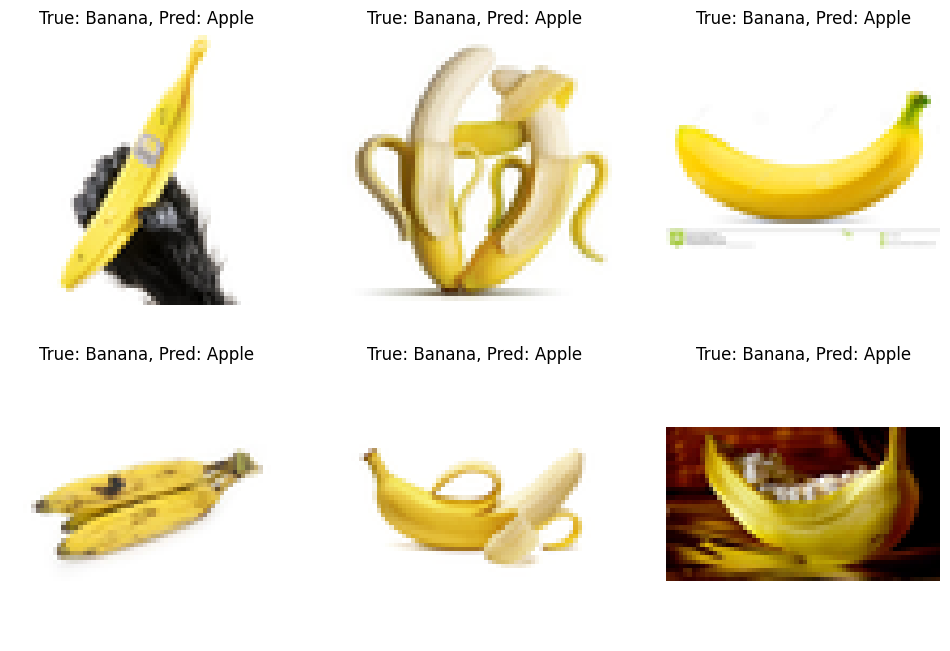

In [55]:
visualize_incorrect(model3, test_dataset)



In [56]:
# 70 % Synthetic 30% Original

combined_indices = sample_indices(synthetic_indices, original_indices, syn_ratio=0.7, orig_ratio=0.3)

combined_dataset = Subset(synthetic_dataset + original_dataset, combined_indices)
train_loader4 = DataLoader(combined_dataset, batch_size=32, shuffle=True)

In [57]:
# Model for 70 % Synthetic 30% Original

model4 = CNN(classes)     
model4.apply(init_weights)
    
train_model(model4, train_loader4)
evaluate_model(model4, test_loader)

Epoch [1/10], Loss: 1.0969
Epoch [2/10], Loss: 0.5098
Epoch [3/10], Loss: 0.2147
Epoch [4/10], Loss: 0.1703
Epoch [5/10], Loss: 0.0586
Epoch [6/10], Loss: 0.0373
Epoch [7/10], Loss: 0.0283
Epoch [8/10], Loss: 0.0195
Epoch [9/10], Loss: 0.0141
Epoch [10/10], Loss: 0.0098
Accuracy: 67.27%


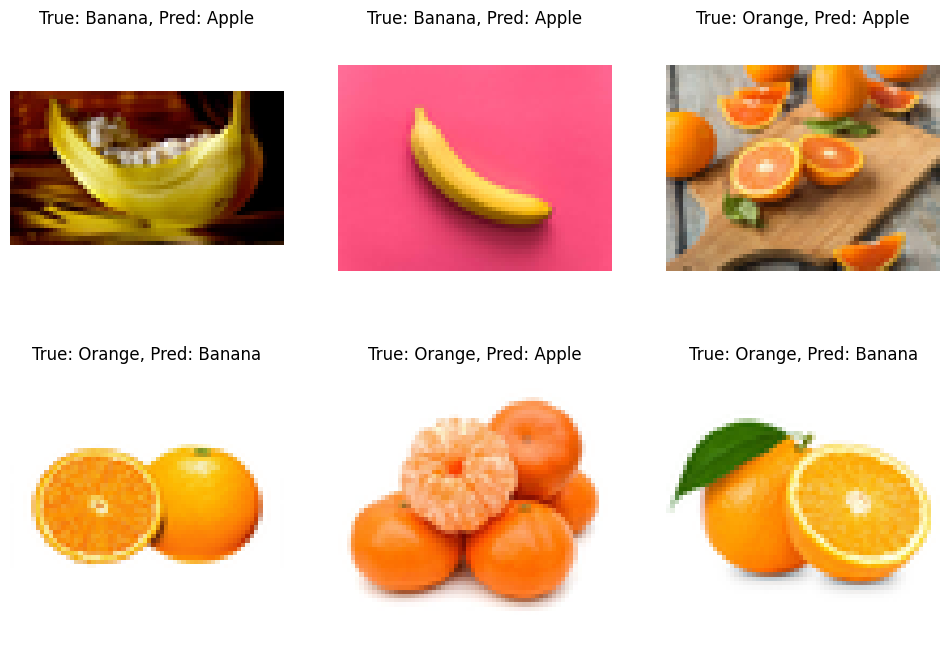

In [58]:
visualize_incorrect(model4, test_dataset)

